This script mostly follows [the standard CIFAR10 Pytorch example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). It extracts a single "channel" from the dataset （if image inputs are in RGB and treats it as a greyscale image or directly extract greyscale image.

The steps are:

1. Load and normalizing the FRDEEP-N/FRDEEP-F training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

First import some standard python libraries for plotting stuff and handling arrays:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Then import the pytorch and torchvision libraries:

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

Then import the pytorch neural network stuff:

In [3]:
import torch.nn as nn
import torch.nn.functional as F

Then import the oprimization library from pytorch:

In [4]:
import torch.optim as optim

Finally import the FRDEEP pytorch dataset class. This is not provided with pytorch, you need to [grab it from the FRDEEP github](
https://github.com/HongmingTang060313/FR-DEEP/blob/master/htru3.py).

In [5]:
from FRDEEP import FRDEEPN

Define a torchvision transform to extract a single channel from the multi-channel dataset:

In [6]:
def select_channel(x,c,color=None):
    
    from PIL import Image
    
    np_img = np.array(x, dtype=np.uint8)
    if color=='RGB':
        ch_img = np_img[:,:,c]
    elif color=='grey':
        ch_img = np_img
    img = Image.fromarray(ch_img,'L')
    return img

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]. The first transform extracts Channel 0 (DM surface) from the data.

Input images can be cropped if needed using the crop(img,x,y,w,h) function, this function can be disable 

In [7]:
transform = transforms.Compose(
    [transforms.Lambda(lambda x: select_channel(x,0,'grey')), # 'RGB' in the context of htru1
     transforms.Lambda(lambda x: transforms.functional.crop(x,66, 66, 18, 18)), # crop image [20190423 22:34]
     transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

Load in the training and test datasets. The first time you do this it will download the data to your working directory, but once the data is there it will just use it without repeating the download.

In [8]:
trainset = FRDEEPN(root='./NVSS_data', train=True, download=False, transform=transform) # root='./data' in the context of htru1 
batch_size_train = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

(550, 150, 150, 1)


In [9]:
testset = FRDEEPN(root='./NVSS_data', train=False, download=False, transform=transform) # root='./data' in the context of htru1 
batch_size_test = 2
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

(50, 150, 150, 1)


There are two classes in this dataset: FRI and FRII:

In [10]:
classes = ('FRI', 'FRII')

A little function to display images nicely:

In [11]:
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Take a look at some randomly selected samples to see how they appear:

In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(np.shape(images))

torch.Size([2, 1, 18, 18])


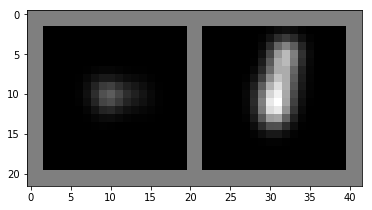

  FRI  FRII


In [13]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size_train)))

Define a neural network that takes 1-channel images as input:

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 120) # (16 * 5 * 5,120) in the case of pulsars  (16 * 3 * 3) for NVSS [20190423 22:34]
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # conv1 output width: input_width - (kernel_size - 1) => 18 - (5-1) = 14
        # pool 1 output width: int(input_width/2) => 7
        x = self.pool(F.relu(self.conv1(x)))
        # conv2 output width: input_width - (kernel_size - 1) => 7 - (5-1) = 3
        # too small to pool
        # x = self.pool(F.relu(self.conv2(x)))  cancel pool 2 for NVSS [20190423 22:34]
        x = F.relu(self.conv2(x)) # cancel pool 2 for NVSS [20190423 22:34]
        x = x.view(-1, 16 * 3 * 3) # (-1,16 * 5 * 5) in the case of pulsars (16 * 3 * 3) for NVSS [20190423 22:34]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
net = Net()
summary(net,(1,18,18)) # (1,32,32) for htrl1 (1,18,18) for NVSS

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 14, 14]             156
         MaxPool2d-2              [-1, 6, 7, 7]               0
            Conv2d-3             [-1, 16, 3, 3]           2,416
            Linear-4                  [-1, 120]          17,400
            Linear-5                   [-1, 84]          10,164
            Linear-6                   [-1, 10]             850
Total params: 30,986
Trainable params: 30,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


We'll use Classification Cross-Entropy loss and Adagrad with momentum for optimization:

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.01)

Run a few epochs of training:

In [17]:
nepoch = 2  # number of epochs
print_num = 50
for epoch in range(nepoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_num == (print_num-1):    # print every 50 mini-batches [2000 in the context of htru1]
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_num))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.883
[1,   100] loss: 0.707
[1,   150] loss: 0.670
[1,   200] loss: 0.681
[1,   250] loss: 0.685
[2,    50] loss: 0.628
[2,   100] loss: 0.490
[2,   150] loss: 0.634
[2,   200] loss: 0.510
[2,   250] loss: 0.598
Finished Training


Now we'll try out a couple of test samples just for visual kicks. First load them up and take a look at the true labels:

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

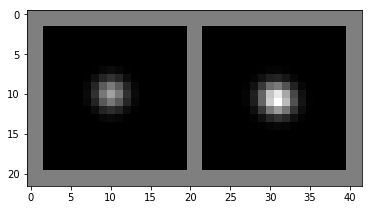

GroundTruth:    FRI  FRII


In [19]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size_test)))

Then see what the network predicts that they are:

In [20]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size_test)))

Predicted:    FRI  FRII


Now calculate the overall accuracy of the network on **all** the test images:

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 50 test images: 76 %


This is a seriously imbalanced dataset, so let's take a look at the accuracy for individual classes:

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size_test):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


In [24]:
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   FRI : 50 %
Accuracy of  FRII : 96 %
